In this notebook, we are going to test all the datasets and visualize some results to ensure global explainability and to verify that the model is able to interpret the predictions reasonably.

### MNIST

In [1]:
import torch.nn.functional as F
from torch_explain.nn.concepts import ConceptReasoningLayer, IntpLinearLayer1, IntpLinearLayer2, IntpLinearLayer3
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import logging
import warnings
warnings.filterwarnings('ignore')
# Set the logging level for matplotlib to WARNING to suppress debug information
logging.getLogger('matplotlib').setLevel(logging.WARNING)


PATH = 'models/'

2024-07-21 00:54:01,351 - matplotlib - DEBUG - matplotlib data path: d:\Github\pytorch_explain\env\Lib\site-packages\matplotlib\mpl-data
2024-07-21 00:54:01,368 - matplotlib - DEBUG - CONFIGDIR=C:\Users\a_h9\.matplotlib
2024-07-21 00:54:01,520 - matplotlib - DEBUG - interactive is False
2024-07-21 00:54:01,521 - matplotlib - DEBUG - platform is win32
2024-07-21 00:54:01,591 - matplotlib - DEBUG - CACHEDIR=C:\Users\a_h9\.matplotlib
2024-07-21 00:54:01,603 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\a_h9\.matplotlib\fontlist-v390.json
2024-07-21 00:54:02,141 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-07-21 00:54:02,145 - matplotlib.pyplot - DEBUG - Loaded backend inline version unknown.


In [2]:
import pickle
with open('transformed_MNIST/test_data.pkl', 'rb') as f:
  x_test, c_test, y_test = pickle.load(f)

x_test.shape, c_test.shape, y_test.shape

((10000, 512), (10000, 20), (10000,))

In [3]:
def get_labels_from_concept(concept):
    '''Return the labels c1 and c2 from the concepts
        i.e. the indices where the concept is True'''
    cs = np.where(concept==1)[0]
    return [cs[0], cs[1]-10] 

In [4]:
get_labels_from_concept(c_test[0])

[7, 2]

In [5]:
def create_df(x):
    df = pd.DataFrame()
    c1 = []
    c2 = []
    for i in range(len(x)):
        c11, c22 = get_labels_from_concept(x[i])
        c1.append(c11)
        c2.append(c22)   
    df['c1'] = c1
    df['c2'] = c2
    df['sum'] = df['c1'] + df['c2']
    return df

df = create_df(c_test)
df.head()


,c1,c2,sum
0,7,2,9
1,2,8,10
2,1,6,7
3,0,0,0
4,4,4,8


In [6]:
x = torch.from_numpy(x_test).float()
c = torch.from_numpy(c_test).float()
y = torch.from_numpy(y_test).long()
y = F.one_hot(y.long().ravel()).float()

DCR

In [7]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(32, c.shape[1], embedding_size),
)

task_predictor = ConceptReasoningLayer(embedding_size, y.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [8]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_DCRBase_MNIST_Addition.pth')))

<All keys matched successfully>

In [9]:
cem = model[0]
dcr = model[1]
cem.eval()
dcr.eval()
c_emb , c_pred = cem(x)
y_pred, sign_attn, filter_attn = dcr(c_emb, c_pred, return_attn=True)


LLR 1

In [10]:
isBias = True

In [33]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(32, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer1(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [34]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR1_MNIST_Addition.pth')))

<All keys matched successfully>

In [36]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [37]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 19]), torch.Size([10000, 20, 19]), torch.Size([10000, 19]))

In [38]:
dataframes = [pd.DataFrame() for _ in range(19)]
for i in range(19):
    dataframes[i]['c1'] = df['c1']
    dataframes[i]['c2'] = df['c2']
    dataframes[i]['sum'] = df['sum']
    for j in range(20):
        dataframes[i][f'w_{j}'] = weights[:,j,i].detach().numpy()
    dataframes[i][f'y_pred_{i}'] = y_pred[:,i].detach().numpy()

In [43]:
weights[0]

tensor([[4.1740e-14, 2.6503e-03, 7.4925e-11, 3.2198e-04, 1.6310e-02, 3.3993e-01,
         3.7936e-06, 1.0000e+00, 1.9054e-04, 3.7856e-04, 9.2109e-01, 7.1884e-02,
         6.4176e-03, 9.9689e-01, 1.0000e+00, 1.5050e-01, 9.9626e-01, 9.9885e-01,
         5.6493e-07],
        [1.3005e-05, 4.2513e-03, 8.5216e-01, 9.9074e-01, 9.9679e-01, 6.9954e-01,
         5.5074e-01, 2.4243e-05, 1.4748e-01, 1.9110e-01, 1.6150e-01, 1.5579e-04,
         3.3319e-02, 4.5514e-06, 2.1044e-02, 4.6513e-02, 9.0431e-05, 1.2506e-01,
         1.4980e-14],
        [5.5082e-08, 7.4711e-05, 4.6284e-01, 2.7776e-01, 9.9693e-01, 1.0755e-01,
         9.9999e-01, 7.5665e-05, 1.4119e-05, 9.6134e-01, 9.9973e-01, 3.2029e-01,
         9.9999e-01, 1.5175e-09, 4.0110e-04, 3.0863e-02, 6.0184e-01, 3.4402e-01,
         9.6243e-13],
        [3.5278e-10, 9.4208e-02, 1.0286e-05, 4.8799e-09, 9.9964e-01, 7.3783e-01,
         4.1484e-04, 9.9905e-01, 1.3093e-05, 3.2599e-01, 9.9999e-01, 1.5100e-03,
         9.9974e-01, 4.1741e-02, 9.8075e-01

In [40]:
dataframes[9]

,c1,c2,sum,w_0,w_1,w_2,w_3,w_4,w_5,w_6,...,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,y_pred_9
0,7,2,9,3.785565e-04,0.191097,9.613380e-01,0.325993,9.984185e-01,0.344217,3.050644e-04,...,9.879028e-01,0.995656,0.003612,2.784603e-01,0.998603,1.279700e-02,8.270941e-09,7.677766e-01,0.999501,1.809106
1,2,8,10,7.214845e-08,0.967724,5.166210e-08,0.730293,9.967490e-01,0.000001,2.784768e-14,...,9.940543e-01,0.828630,0.226246,1.694958e-02,0.408839,6.193694e-12,9.659688e-01,6.431548e-08,0.306421,-0.080397
2,1,6,7,6.488669e-03,0.034773,2.601284e-03,0.999916,1.484699e-08,0.999184,2.836019e-06,...,9.807990e-02,0.239202,0.999919,9.522787e-03,0.999633,2.552114e-11,9.651671e-01,9.946931e-01,0.787345,0.662902
3,0,0,0,6.328195e-01,0.998571,3.182652e-04,0.996371,7.046875e-01,0.036064,5.642261e-09,...,9.408283e-01,0.003340,0.999039,9.712337e-01,0.970686,2.111204e-03,9.902489e-01,3.161066e-02,0.407785,-0.866313
4,4,4,8,2.113861e-05,0.899551,1.411793e-05,0.999811,2.614068e-14,0.998569,9.868692e-08,...,7.190283e-01,0.034879,0.999387,2.157185e-12,0.999406,6.297586e-05,6.699868e-01,9.305017e-01,0.428305,0.073100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,9,11,3.490455e-05,0.995237,3.682107e-01,0.999972,9.789813e-01,0.995498,2.088181e-05,...,8.500778e-01,0.927589,0.999861,8.916861e-04,0.999739,4.581569e-01,4.907470e-09,9.859634e-01,0.856182,1.673775
9996,3,4,7,3.950121e-09,0.963405,8.463159e-07,0.825406,9.970191e-01,0.002755,4.326232e-11,...,9.897836e-01,0.795910,0.023191,2.139578e-02,0.995911,2.139079e-09,9.282137e-01,8.591508e-05,0.892300,1.060381
9997,4,6,10,1.078704e-04,0.273601,1.117662e-02,0.999756,1.905667e-12,0.998417,8.447335e-06,...,2.281834e-08,0.807548,0.999496,8.971384e-12,0.999392,1.029312e-07,4.969972e-01,9.930860e-01,0.226697,-0.331541
9998,5,9,14,5.808950e-05,0.998715,3.054353e-03,0.999896,9.972382e-01,0.982202,2.543677e-08,...,9.402056e-01,0.960910,0.998891,1.493792e-04,0.999697,2.608630e-02,2.715756e-04,9.809101e-01,0.039714,1.188680


LLR 2

In [44]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(32, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer2(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [45]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR2_MNIST_Addition.pth')))

<All keys matched successfully>

In [46]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [47]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 19]), torch.Size([10000, 40, 19]), torch.Size([10000, 19]))

In [48]:
dataframes = [pd.DataFrame() for _ in range(19)]
for i in range(19):
    dataframes[i]['c1'] = df['c1']
    dataframes[i]['c2'] = df['c2']
    dataframes[i]['sum'] = df['sum']
    for j in range(20):
        dataframes[i][f'w_{j}_pos'] = weights[:,j,i].detach().numpy()
        dataframes[i][f'w_{j}_neg'] = weights[:,j+20,i].detach().numpy()
    dataframes[i][f'y_pred_{i}'] = y_pred[:,i].detach().numpy()

In [49]:
dataframes[1]

,c1,c2,sum,w_0_pos,w_0_neg,w_1_pos,w_1_neg,w_2_pos,w_2_neg,w_3_pos,...,w_15_neg,w_16_pos,w_16_neg,w_17_pos,w_17_neg,w_18_pos,w_18_neg,w_19_pos,w_19_neg,y_pred_1
0,7,2,9,0.001866,0.002748,0.015347,0.136685,0.013939,0.001290,0.062863,...,0.690094,9.183031e-01,7.683395e-01,2.648317e-08,3.237189e-15,0.549576,5.190829e-01,0.015375,7.527389e-02,-0.537747
1,2,8,10,0.003593,0.000770,0.000090,0.249463,0.021212,0.002913,0.001039,...,0.000421,3.361567e-02,6.861451e-02,8.986036e-03,3.703786e-01,0.000012,1.656804e-08,0.008009,6.711063e-03,-5.645522
2,1,6,7,0.122326,0.374004,0.872093,0.336661,0.981962,0.968717,0.000950,...,0.000010,3.946016e-09,1.141310e-12,7.063265e-01,9.856606e-01,0.849496,6.493657e-01,0.143774,1.292538e-01,6.069988
3,0,0,0,0.001672,0.034013,0.570844,0.769039,0.047907,0.010356,0.000591,...,0.975194,6.636877e-03,3.683777e-02,4.248913e-01,6.437535e-01,0.347055,2.770118e-01,0.432342,9.107629e-01,11.750354
4,4,4,8,0.000073,0.000083,0.020123,0.814297,0.528715,0.031273,0.110322,...,0.176866,1.740992e-02,4.222595e-05,2.012679e-01,7.720221e-01,0.929660,4.836197e-01,0.089094,3.328790e-02,1.615073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,9,11,0.000491,0.000083,0.007868,0.861232,0.000041,0.000010,0.044731,...,0.374467,6.345235e-01,9.880583e-02,3.313917e-09,1.932239e-16,0.903297,6.509779e-01,0.051808,1.701784e-02,-2.486801
9996,3,4,7,0.004358,0.002893,0.000370,0.521937,0.112287,0.051557,0.006212,...,0.001847,4.689486e-02,1.310314e-01,1.455036e-01,5.519721e-01,0.375212,3.138967e-01,0.014180,2.018330e-02,2.706883
9997,4,6,10,0.002514,0.006483,0.026396,0.506107,0.868597,0.301856,0.032863,...,0.069136,3.100912e-02,2.875863e-05,2.545791e-01,8.399870e-01,0.837610,5.151669e-01,0.095341,2.542313e-02,0.674133
9998,5,9,14,0.000596,0.000026,0.010172,0.131757,0.063519,0.003030,0.032812,...,0.050113,1.926674e-01,4.127799e-03,8.113985e-06,4.921528e-07,0.053030,1.379871e-01,0.000008,2.296697e-08,-7.352342


LLR 3

In [50]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(32, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer3(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [51]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR3_MNIST_Addition.pth')))

<All keys matched successfully>

In [52]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, cat_weights, biases = llr(c_emb, c_pred, return_params=True)

In [53]:
y_pred.shape, cat_weights.shape, biases.shape

(torch.Size([10000, 19]), torch.Size([10000, 20, 19]), torch.Size([10000, 19]))

In [54]:
dataframes = [pd.DataFrame() for _ in range(19)]
for i in range(19):
    dataframes[i]['c1'] = df['c1']
    dataframes[i]['c2'] = df['c2']
    dataframes[i]['sum'] = df['sum']
    for j in range(20):
        dataframes[i][f'w_{j}'] = weights[:,j,i].detach().numpy()
    dataframes[i][f'y_pred_{i}'] = y_pred[:,i].detach().numpy()

In [55]:
dataframes[1]

,c1,c2,sum,w_0,w_1,w_2,w_3,w_4,w_5,w_6,...,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,y_pred_1
0,7,2,9,0.001866,0.015347,0.013939,0.062863,0.128857,0.947648,6.360583e-02,...,0.000010,0.000007,0.004473,3.275368e-06,0.002220,9.183031e-01,2.648317e-08,0.549576,0.015375,-17.474487
1,2,8,10,0.003593,0.000090,0.021212,0.001039,0.530109,0.744178,6.681679e-04,...,0.000048,0.000151,0.161000,4.009161e-08,0.000560,3.361567e-02,8.986036e-03,0.000012,0.008009,-14.395933
2,1,6,7,0.122326,0.872093,0.981962,0.000950,0.401486,0.982111,1.754397e-05,...,0.023623,0.000645,0.961868,1.252739e-05,0.000036,3.946016e-09,7.063265e-01,0.849496,0.143774,-1.790787
3,0,0,0,0.001672,0.570844,0.047907,0.000591,0.670548,0.734110,4.353460e-04,...,0.019648,0.176467,0.827736,7.195627e-05,0.916950,6.636877e-03,4.248913e-01,0.347055,0.432342,4.073905
4,4,4,8,0.000073,0.020123,0.528715,0.110322,0.000206,0.983507,8.303077e-04,...,0.007396,0.000552,0.979750,4.089794e-03,0.233747,1.740992e-02,2.012679e-01,0.929660,0.089094,-9.685976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,9,11,0.000491,0.007868,0.000041,0.044731,0.106630,0.916310,4.594781e-03,...,0.000821,0.000014,0.844498,1.769447e-06,0.143694,6.345235e-01,3.313917e-09,0.903297,0.051808,-11.638349
9996,3,4,7,0.004358,0.000370,0.112287,0.006212,0.664594,0.784540,7.308245e-03,...,0.000267,0.000298,0.427906,1.966856e-06,0.002477,4.689486e-02,1.455036e-01,0.375212,0.014180,-4.093768
9997,4,6,10,0.002514,0.026396,0.868597,0.032863,0.002470,0.938720,5.782115e-03,...,0.045478,0.000148,0.848047,2.747857e-02,0.099184,3.100912e-02,2.545791e-01,0.837610,0.095341,-9.646285
9998,5,9,14,0.000596,0.010172,0.063519,0.032812,0.004624,0.816799,2.378080e-04,...,0.000157,0.000075,0.853147,8.339520e-08,0.011998,1.926674e-01,8.113985e-06,0.053030,0.000008,-22.483252


_____

In [2]:
x, c, y = datasets.is_bin_even(5)

# Encode target into one-hode y=[y_0, y_1]
y = F.one_hot(y.long().ravel()).float()

# Define the concept_encoder
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer2(embedding_size, y.shape[1], log=True)

# Create a sequential model (cascaded)
model = torch.nn.Sequential(
    concept_encoder, task_predictor)


In [3]:
c_emb , c_pred = concept_encoder(x)
preds , coeffs, biases = task_predictor(c_emb, c_pred, return_params = True)

2024-07-04 17:36:11,383 - torch_explain.nn.concepts - INFO - X: torch.Size([5, 4, 8])
2024-07-04 17:36:11,384 - torch_explain.nn.concepts - INFO - C: torch.Size([5, 4])
2024-07-04 17:36:11,386 - torch_explain.nn.concepts - INFO - Assigned Coeffs (+): torch.Size([5, 4, 2])
2024-07-04 17:36:11,390 - torch_explain.nn.concepts - INFO - Assigned Coeffs (+): tensor([[[0.4494, 0.6038],
         [0.4473, 0.6009],
         [0.4530, 0.5827],
         [0.4506, 0.5835]],

        [[0.4487, 0.6065],
         [0.4473, 0.5954],
         [0.4526, 0.5828],
         [0.4500, 0.5860]],

        [[0.4490, 0.6120],
         [0.4456, 0.5996],
         [0.4525, 0.5805],
         [0.4520, 0.5815]],

        [[0.4496, 0.6052],
         [0.4477, 0.5931],
         [0.4522, 0.5797],
         [0.4489, 0.5913]],

        [[0.4495, 0.6016],
         [0.4478, 0.5957],
         [0.4524, 0.5805],
         [0.4492, 0.5898]]], grad_fn=<SigmoidBackward0>)
2024-07-04 17:36:11,391 - torch_explain.nn.concepts - INFO - Assign

torch.Size([5, 4, 1])
torch.Size([5, 4, 2])


# Dataset 1: Is Bin EVEN

In [50]:
x, c, y = datasets.is_bin_even(100)

# Encode target into one-hode y=[y_0, y_1]
y = F.one_hot(y.long().ravel()).float()

# Define the concept_encoder
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)

# Define the DCR as task predictor
task_predictor = ConceptReasoningLayer(
    embedding_size, y.shape[1])

dummy_c_emb, dummy_c_pred = concept_encoder(x)
dummy_y, dummy_sign, dummy_filter = task_predictor(
    dummy_c_emb, dummy_c_pred, return_attn=True)

global_linearity = ReasoningLinearLayer(
    dummy_sign.shape[1], dummy_filter.shape[1], y.shape[1], modality='NN')

# Create a sequential model (cascaded)
model = torch.nn.Sequential(
    concept_encoder, task_predictor, global_linearity)


model.load_state_dict(torch.load(PATH+'\model_state_dict_LLRNN_IsBinEven.pth'))

<All keys matched successfully>

In [51]:
cem = model[0]
dcr = model[1]
llr = model[2]
cem.eval()
dcr.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, sign_attn, filter_attn = dcr(c_emb, c_pred, return_attn=True)
pred , coeffs, bias = llr(sign_attn, filter_attn, c_pred, return_params=True)

In [52]:
pred = torch.sigmoid(pred) # [0] for y_0, [1] for y_1

In [53]:
df = pd.DataFrame({
    'c_0': c[:, 0],
    'c_1': c[:, 1],
    'c_2': c[:, 2],
    'c_3': c[:, 3],
    'y_true_0': y[:, 0],
    'y_true_1': y[:, 1],
    'y_pred_0': pred[:, 0].detach().numpy(),
    'y_pred_1': pred[:, 1].detach().numpy(),
    'coeffs_c0_y0': coeffs[:,0,0].detach().numpy(),
    'coeffs_c1_y0': coeffs[:,1,0].detach().numpy(),
    'coeffs_c2_y0': coeffs[:,2, 0].detach().numpy(),
    'coeffs_c3_y0': coeffs[:,3, 0].detach().numpy(),
    'coeffs_c0_y1': coeffs[:,0, 1].detach().numpy(),
    'coeffs_c1_y1': coeffs[:,1, 1].detach().numpy(),
    'coeffs_c2_y1': coeffs[:,2, 1].detach().numpy(),
    'coeffs_c3_y1': coeffs[:,3, 1].detach().numpy(),
    'bias_y0': bias[:, 0].detach().numpy(),
    'bias_y1': bias[:, 1].detach().numpy(),
})

#### Important:
For this dataset, a number is even is the $c_3$ is even (i.e. equal to zero).\
The output of $y_0$ is 0 ($y_1$ is 1) means that the number IS EVEN.

In [54]:
df.head()

,c_0,c_1,c_2,c_3,y_true_0,y_true_1,y_pred_0,y_pred_1,coeffs_c0_y0,coeffs_c1_y0,coeffs_c2_y0,coeffs_c3_y0,coeffs_c0_y1,coeffs_c1_y1,coeffs_c2_y1,coeffs_c3_y1,bias_y0,bias_y1
0,0.0,1.0,1.0,1.0,1.0,0.0,0.999750,0.000242,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,5.898506,-6.153701
1,0.0,0.0,0.0,1.0,1.0,0.0,0.999998,0.000002,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,9.926749,-10.257683
2,1.0,1.0,0.0,1.0,1.0,0.0,0.999648,0.000346,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,5.726903,-5.978871
3,1.0,0.0,0.0,0.0,0.0,1.0,0.000015,0.999986,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,-10.519448,10.572951
4,0.0,1.0,0.0,0.0,0.0,1.0,0.000018,0.999983,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,-10.826395,10.885671


In [56]:
dfx = df[df['y_pred_1']>0.5]
dfx[['coeffs_c0_y1', 'coeffs_c1_y1','coeffs_c2_y1','coeffs_c3_y1', 'bias_y1']].mean(axis=0)

coeffs_c0_y1    0.620312
coeffs_c1_y1    0.113863
coeffs_c2_y1    0.132209
coeffs_c3_y1   -8.162221
bias_y1         9.213383
dtype: float32

#### Average weight: Plotting the average weight of each concept (in absolute value) to analyze its importance
We can focus on $y_1$ since it is TRUE (1) when the number is even

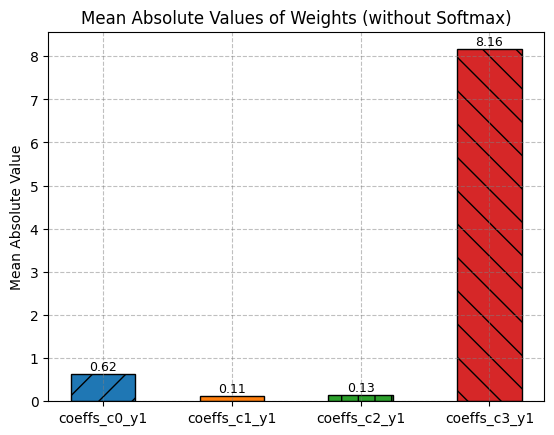

In [7]:
df_1 = df[['coeffs_c0_y1', 'coeffs_c1_y1', 'coeffs_c2_y1', 'coeffs_c3_y1']]

for col in df_1.columns:
    df_1[col] = np.abs(df_1[col])


fig, ax = plt.subplots()


# Assuming df_1 is correctly calculated before this snippet
bar_width = 0.5
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
hatches = ['/', '-', '|', '\\']  # Different hatches for each bar

bars = ax.bar(df_1.columns, df_1.mean(axis=0), bar_width, color=colors, edgecolor='black')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.set_ylabel('Mean Absolute Value')
ax.set_title('Mean Absolute Values of Weights (without Softmax)')
ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)

# Enhanced label positioning
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

Verifying Results:

In [8]:
llr.explain(x, c_pred, sign_attn, filter_attn, mode='global')

[{'class': 'y_0', 'explanation': 'c_3', 'count': 53},
 {'class': 'y_1', 'explanation': '~c_3', 'count': 47}]

______

In [18]:
x, c, y = datasets.mux41Mod(1600)

# Encode target into one-hode y=[y_0, y_1]
y = F.one_hot(y.long().ravel()).float()

# Define the concept_encoder
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)

# Define the DCR as task predictor
task_predictor = ConceptReasoningLayer(
    embedding_size, y.shape[1])

dummy_c_emb, dummy_c_pred = concept_encoder(x)
dummy_y, dummy_sign, dummy_filter = task_predictor(
    dummy_c_emb, dummy_c_pred, return_attn=True)

global_linearity = ReasoningLinearLayer(
    dummy_sign.shape[1], dummy_filter.shape[1], y.shape[1], modality='NN')

# Create a sequential model (cascaded)
model = torch.nn.Sequential(
    concept_encoder, task_predictor, global_linearity)


model.load_state_dict(torch.load('Models\model_state_dict_LLRNN_mux41Mod.pth'))

<All keys matched successfully>

In [19]:
cem = model[0]
dcr = model[1]
llr = model[2]
cem.eval()
dcr.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, sign_attn, filter_attn = dcr(c_emb, c_pred, return_attn=True)
pred , coeffs, bias = llr(sign_attn, filter_attn, c_pred, return_params=True)

In [20]:
pred = torch.sigmoid(pred) # [0] for y_0, [1] for y_1

In [40]:
df = pd.DataFrame({
    # 'x_0': x[:, 0],
    # 'x_1': x[:, 1],
    # 'x_2': x[:, 2],
    # 'x_6': x[:, 6],
    
    'c_0': c[:, 0],
    'c_1': c[:, 1],
    'c_2': c[:, 2],
    'c_3': c[:, 3],
    'c_4': c[:, 4],
    'c_5': c[:, 5],
    
    'y_true_0': y[:, 0],
    'y_true_1': y[:, 1],
    'y_true_2': y[:, 2],
    'y_true_3': y[:, 3],
    
    'y_pred_0': pred[:, 0].detach().numpy(),
    'y_pred_1': pred[:, 1].detach().numpy(),
    'y_pred_2': pred[:, 2].detach().numpy(),
    'y_pred_3': pred[:, 3].detach().numpy(),
    
    'coeffs_c0_y0': coeffs[:,0,0].detach().numpy(),
    'coeffs_c1_y0': coeffs[:,1,0].detach().numpy(),
    'coeffs_c2_y0': coeffs[:,2,0].detach().numpy(),
    'coeffs_c3_y0': coeffs[:,3,0].detach().numpy(),
    'coeffs_c4_y0': coeffs[:,4,0].detach().numpy(),
    'coeffs_c5_y0': coeffs[:,5,0].detach().numpy(),
        
    
    'coeffs_c0_y1': coeffs[:,0, 1].detach().numpy(),
    'coeffs_c1_y1': coeffs[:,1, 1].detach().numpy(),
    'coeffs_c2_y1': coeffs[:,2, 1].detach().numpy(),
    'coeffs_c3_y1': coeffs[:,3, 1].detach().numpy(),
    'coeffs_c4_y1': coeffs[:,4, 1].detach().numpy(),
    'coeffs_c5_y1': coeffs[:,5, 1].detach().numpy(),

    'coeffs_c0_y2': coeffs[:,0,2].detach().numpy(),
    'coeffs_c1_y2': coeffs[:,1,2].detach().numpy(),
    'coeffs_c2_y2': coeffs[:,2,2].detach().numpy(),
    'coeffs_c3_y2': coeffs[:,3,2].detach().numpy(),
    'coeffs_c4_y2': coeffs[:,4,2].detach().numpy(),
    'coeffs_c5_y2': coeffs[:,5,2].detach().numpy(),
        
    
    'coeffs_c0_y3': coeffs[:,0, 3].detach().numpy(),
    'coeffs_c1_y3': coeffs[:,1, 3].detach().numpy(),
    'coeffs_c2_y3': coeffs[:,2, 3].detach().numpy(),
    'coeffs_c3_y3': coeffs[:,3, 3].detach().numpy(),
    'coeffs_c4_y3': coeffs[:,4, 3].detach().numpy(),
    'coeffs_c5_y3': coeffs[:,5, 3].detach().numpy(),

    'bias_y0': bias[:, 0].detach().numpy(),
    'bias_y1': bias[:, 1].detach().numpy(),
})

#### Important:
For this dataset, a number is even is the $c_3$ is even (i.e. equal to zero).\
The output of $y_0$ is 0 ($y_1$ is 1) means that the number IS EVEN.

In [22]:
x[0]

tensor([0.3745, 0.9507, 0.7320, 0.5987, 0.1560, 0.1560])

In [32]:
df[['c_0','c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'y_true_0', 'y_true_1','coeffs_c0_y1', 'coeffs_c1_y1', 'coeffs_c2_y1', 'coeffs_c3_y1', 'coeffs_c4_y1', 'coeffs_c5_y1', 'bias_y0']].head(10)

,c_0,c_1,c_2,c_3,c_4,c_5,y_true_0,y_true_1,coeffs_c0_y1,coeffs_c1_y1,coeffs_c2_y1,coeffs_c3_y1,coeffs_c4_y1,coeffs_c5_y1,bias_y0
0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.381366,-1.028146,-0.866733,-1.084005,-2.253977,-0.616226,3.589506
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,-1.597814,-1.256276,-1.056633,-1.318340,-11.182923,-0.785892,-3.256577
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.187940,-1.373238,-1.179430,-1.460706,-7.818664,-0.860784,-5.435703
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.347145,-1.181893,-0.866480,-1.250034,-2.266643,-0.588076,5.894283
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.345824,-1.028179,-0.995485,-1.085493,-10.986180,-0.616026,1.904581
5,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.421649,-1.418182,-1.181632,-1.317788,-11.221576,-0.789722,-3.359461
6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.424993,-1.338716,-0.872755,-1.416470,-4.479455,-0.714575,0.138668
7,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.437029,-1.068100,-1.166968,-1.150767,-7.175263,-0.878636,-3.985296
8,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,-1.424071,-1.415143,-1.005434,-1.318107,-11.222322,-0.786496,-4.172481
9,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.188752,-1.028115,-1.002900,-1.253249,-2.257141,-0.601958,4.216529


In [41]:
dfx = df[df['y_pred_2']>0.5]

In [42]:
df[[#'coeffs_c0_y1', 'coeffs_c1_y1', 'coeffs_c2_y1', 'coeffs_c3_y1', 'coeffs_c4_y1', 'coeffs_c5_y1',
      'coeffs_c0_y2', 'coeffs_c1_y2', 'coeffs_c2_y2', 'coeffs_c3_y2', 'coeffs_c4_y2', 'coeffs_c5_y2',
   #      'coeffs_c0_y3', 'coeffs_c1_y3', 'coeffs_c2_y3', 'coeffs_c3_y3', 'coeffs_c4_y3', 'coeffs_c5_y3'
     ]].mean(axis=0)

coeffs_c0_y2   -0.354892
coeffs_c1_y2   -0.350413
coeffs_c2_y2   -0.302068
coeffs_c3_y2   -0.408090
coeffs_c4_y2    9.732347
coeffs_c5_y2   -0.167935
dtype: float32

#### Average weight: Plotting the average weight of each concept (in absolute value) to analyze its importance
We can focus on $y_1$ since it is TRUE (1) when the number is even

In [10]:
x = dfx.mean(axis=0)
np.abs(x)

c_0             0.621236
c_1             0.624340
c_2             0.625272
c_3             0.624030
c_4             0.498913
c_5             0.497361
y_true_0        0.007141
y_true_1        0.992859
y_pred_0        0.011811
y_pred_1        0.988190
coeffs_c0_y0    1.861761
coeffs_c1_y0    0.223784
coeffs_c2_y0    0.401960
coeffs_c3_y0    0.053050
coeffs_c4_y0    5.669417
coeffs_c5_y0    3.597233
coeffs_c0_y1    1.861831
coeffs_c1_y1    0.223815
coeffs_c2_y1    0.401988
coeffs_c3_y1    0.053082
coeffs_c4_y1    5.669637
coeffs_c5_y1    3.597371
bias_y0         0.273964
bias_y1         0.273965
dtype: float32

(0.0, 6.0)

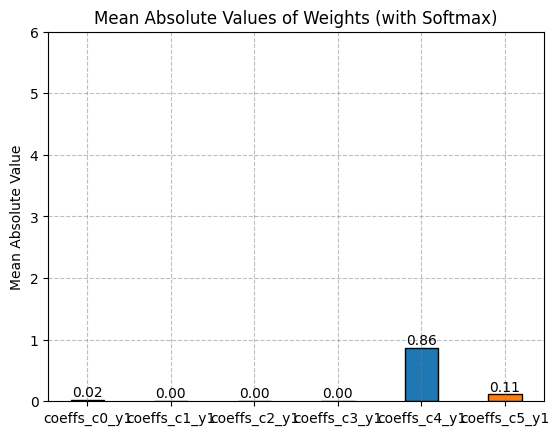

In [12]:
df_1 = dfx[['coeffs_c0_y1', 'coeffs_c1_y1', 'coeffs_c2_y1', 'coeffs_c3_y1', 'coeffs_c4_y1', 'coeffs_c5_y1' ]]

x = df_1.mean(axis=0)
np.abs(x)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

fig, ax = plt.subplots()

# Assuming df_1 is correctly calculated before this snippet
bar_width = 0.4
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
hatches = ['/', '\\', '-']  # Different hatches for each bar

bars = ax.bar(df_1.columns, softmax(x), bar_width, color=colors, edgecolor='black')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='black')

ax.set_ylabel('Mean Absolute Value')
ax.set_title('Mean Absolute Values of Weights (with Softmax)')
ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
ax.set_ylim(0, 6)


Verifying Results:

In [8]:
coeffs[0]


tensor([[-5.7040,  5.5709],
        [-0.1465, -0.3502],
        [-5.3853,  4.9804]], grad_fn=<SelectBackward0>)

In [9]:
soft_coeffs = torch.softmax(
            torch.abs(
                coeffs
            ), dim=1)

soft_coeffs[0, :, 0], soft_coeffs[0, :, 1]

(tensor([0.5777, 0.0022, 0.4201], grad_fn=<SelectBackward0>),
 tensor([0.6413, 0.0035, 0.3553], grad_fn=<SelectBackward0>))

In [10]:
llr.explain(x[:10], c_pred[:10], sign_attn[:10], filter_attn[:10], mode='global')

[{'class': 'y_0', 'explanation': '~c_1', 'count': 3},
 {'class': 'y_0', 'explanation': '', 'count': 4},
 {'class': 'y_1', 'explanation': 'c_0', 'count': 2},
 {'class': 'y_1', 'explanation': '', 'count': 1}]